In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


In [2]:
# Load the dataset
df = pd.read_csv("data/movies_2015_2023_preprocessed_genre.csv")
df.head()

,title,release_year,language,genre,overview,vote_average,vote_count,popularity,cleaned_overview
0,Pad Man,2018,Indisch,Humor,upon realizing extent woman affected menses se...,7.420,200.0,7.036,upon realizing extent woman affected menses se...
1,Tamasha,2015,Indisch,Humor,meeting vacation ved tara sense connection vow...,6.720,141.0,8.770,meeting vacation ved tara sense connection vow...
2,Tu Jhoothi Main Makkaar,2023,Indisch,Humor,earn extra cash mickey help couple break life ...,6.253,144.0,10.045,earn extra cash mickey help couple break life ...
3,Hindi Medium,2017,Indisch,Humor,mita raj batra affluent couple delhi chandni c...,7.300,166.0,7.001,mita raj batra affluent couple delhi chandni c...
4,Dilwale,2015,Indisch,Humor,raj mafia member one day meet girl meera chasi...,6.648,301.0,11.501,raj mafia member one day meet girl meera chasi...


In [ ]:
# Check for missing values and remove them
df_cleaned = df.dropna(subset=['cleaned_overview', 'language', 'genre'])
df_cleaned.head()

,title,release_year,language,genre,overview,vote_average,vote_count,popularity,cleaned_overview
0,Pad Man,2018,Indisch,Humor,upon realizing extent woman affected menses se...,7.420,200.0,7.036,upon realizing extent woman affected menses se...
1,Tamasha,2015,Indisch,Humor,meeting vacation ved tara sense connection vow...,6.720,141.0,8.770,meeting vacation ved tara sense connection vow...
2,Tu Jhoothi Main Makkaar,2023,Indisch,Humor,earn extra cash mickey help couple break life ...,6.253,144.0,10.045,earn extra cash mickey help couple break life ...
3,Hindi Medium,2017,Indisch,Humor,mita raj batra affluent couple delhi chandni c...,7.300,166.0,7.001,mita raj batra affluent couple delhi chandni c...
4,Dilwale,2015,Indisch,Humor,raj mafia member one day meet girl meera chasi...,6.648,301.0,11.501,raj mafia member one day meet girl meera chasi...


In [4]:
# Check the data types of the columns
print(df_cleaned.dtypes)

title                object
release_year          int64
language             object
genre                object
overview             object
vote_average        float64
vote_count          float64
popularity          float64
cleaned_overview     object
dtype: object


In [5]:
df_cleaned['combined_text'] = (
    df_cleaned['cleaned_overview'] + ' ' + 
    df_cleaned['genre'] + ' ' + 
    df_cleaned['vote_average'].astype(str) + ' ' + 
    df_cleaned['vote_count'].astype(str) + ' ' + 
    df_cleaned['popularity'].astype(str)
)

df_cleaned[['combined_text']].head()

/tmp/ipykernel_22139/3861531804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['combined_text'] = (


,combined_text
0,upon realizing extent woman affected menses se...
1,meeting vacation ved tara sense connection vow...
2,earn extra cash mickey help couple break life ...
3,mita raj batra affluent couple delhi chandni c...
4,raj mafia member one day meet girl meera chasi...


In [6]:
# Define features (X) and target (y)
X = df_cleaned['combined_text']
y = df_cleaned['language']

In [7]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Extraction Using TF-IDF

In [8]:
# Handle missing values by replacing NaN with an empty string
X_train = X_train.fillna('')
X_test = X_test.fillna('')


In [9]:
# Use TF-IDF Vectorizer to extract features
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=30000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [10]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the 'language' column
y_encoded = label_encoder.fit_transform(df['language'])

# Print the mapping of languages to numerical labels
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'Amerikanisch': np.int64(0), 'Deutsch': np.int64(1), 'Französisch': np.int64(2), 'Indisch': np.int64(3), 'Italienisch': np.int64(4), 'Spanisch': np.int64(5)}


## Implementing KNN Classifier

In [11]:
# Initialize the KNN classifier with default parameters
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine', weights='distance')

# Train the KNN model
knn.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = knn.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Initial Test Accuracy: {accuracy:.3f}')
print(classification_report(y_test, y_pred))


Initial Test Accuracy: 0.580
              precision    recall  f1-score   support

Amerikanisch       0.68      0.66      0.67       905
     Deutsch       0.52      0.46      0.49       359
 Französisch       0.57      0.51      0.54       529
     Indisch       0.60      0.71      0.65       366
 Italienisch       0.47      0.39      0.43       312
    Spanisch       0.52      0.61      0.56       629

    accuracy                           0.58      3100
   macro avg       0.56      0.56      0.56      3100
weighted avg       0.58      0.58      0.58      3100



## Hyperparameter Tuning with Grid Search

In [12]:
# Define the parameter grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],  # Try different neighbor counts
    'weights': ['uniform', 'distance'],  # Uniform or distance-weighted
    'metric': ['cosine']  # We stick with cosine similarity
}

In [13]:
# Use GridSearchCV to find the best hyperparameters
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_knn.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/codespace/.local/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['cosine'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [14]:
# Output the best parameters and the best score
print(f'Best parameters: {grid_search_knn.best_params_}')
print(f'Best cross-validation accuracy: {grid_search_knn.best_score_:.3f}')

Best parameters: {'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}
Best cross-validation accuracy: 0.597


In [15]:
# Make predictions on the test set with the best model
best_knn = grid_search_knn.best_estimator_
y_pred_best = best_knn.predict(X_test_tfidf)

In [16]:
# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Test Accuracy after tuning: {accuracy_best:.3f}')
print(classification_report(y_test, y_pred_best))

Test Accuracy after tuning: 0.626
              precision    recall  f1-score   support

Amerikanisch       0.67      0.78      0.72       905
     Deutsch       0.65      0.43      0.52       359
 Französisch       0.65      0.54      0.59       529
     Indisch       0.71      0.70      0.70       366
 Italienisch       0.61      0.35      0.45       312
    Spanisch       0.52      0.67      0.59       629

    accuracy                           0.63      3100
   macro avg       0.63      0.58      0.59      3100
weighted avg       0.63      0.63      0.62      3100



## Evaluating the Model

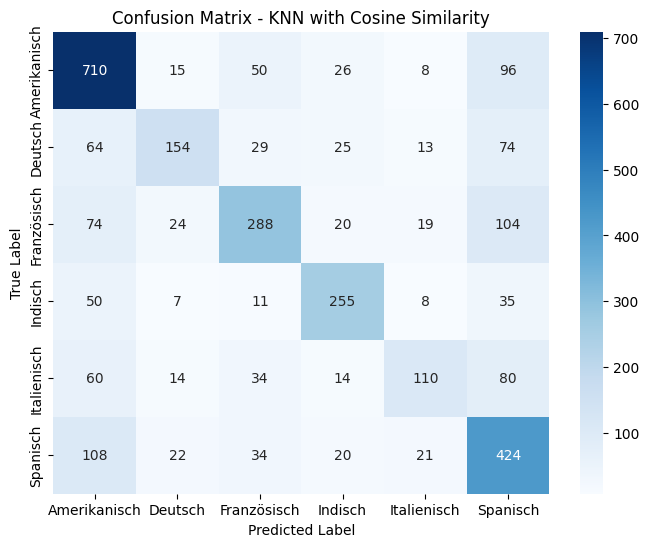

In [17]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_knn.classes_, yticklabels=best_knn.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN with Cosine Similarity')
plt.show()
